### Cyril Kfouri
# Lab 5: Predicting the categories of BBC News
 
Test multiple combinations of Vectorization and ML/DL models an compare their performance in predicting the categories of BBC News: 
Create a pipeline with the following different combinations : 

- CountVectorizer + LogisticRegression
- TFIDF + LogisticRegression
- TFIDF + MLP (NN)
- TFIDF + Dense model (Keras fully connected NN)
- CountVectorizer + Dense model (Keras fully connected NN)
- Word2Vec + BiLSTM
- TFIDF + LinearSVC


Then propose other combinations

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

Read the data 

In [2]:
news = pd.read_csv('bbc-news-data.csv', sep ='\t')
news

category filename                              title  \
0     business  001.txt  Ad sales boost Time Warner profit   
1     business  002.txt   Dollar gains on Greenspan speech   
2     business  003.txt  Yukos unit buyer faces loan claim   
3     business  004.txt  High fuel prices hit BA's profits   
4     business  005.txt  Pernod takeover talk lifts Domecq   
...        ...      ...                                ...   
2220      tech  397.txt   BT program to beat dialler scams   
2221      tech  398.txt    Spam e-mails tempt net shoppers   
2222      tech  399.txt            Be careful how you code   
2223      tech  400.txt    US cyber security chief resigns   
2224      tech  401.txt   Losing yourself in online gaming   

                                                content  
0      Quarterly profits at US media giant TimeWarne...  
1      The dollar has hit its highest level against ...  
2      The owners of embattled Russian oil giant Yuk...  
3      British Airways has blamed high fuel prices f...  
4      Shares in UK drinks and food firm Allied Dome...  
...                                                 ...  
2220   BT is introducing two initiatives to help bea...  
2221   Computer users across the world continue to i...  
2222   A new European directive could put software w...  
2223   The man making sure US computer networks are ...  
2224   Online role playing games are time-consuming,...  

[2225 rows x 4 columns]

Checking for null values 

In [3]:
news.isnull().sum()

category    0
filename    0
title       0
content     0
dtype: int64

Checking for unique values for subject. We want both data frames to have a similar distribution.

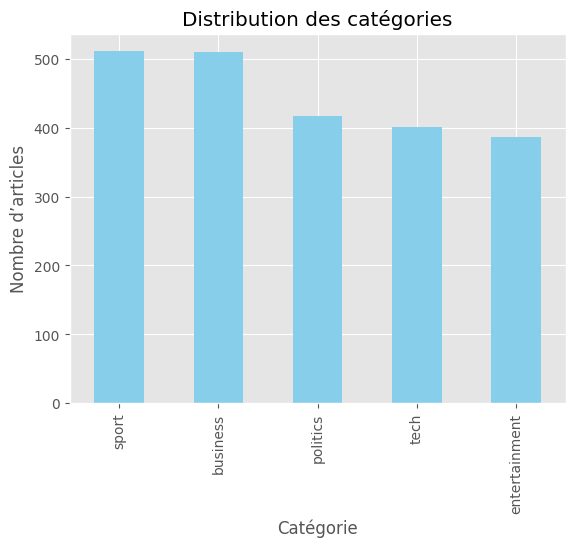

In [4]:
news['category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution des catégories')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d’articles')
plt.show()

Drop the date from the dataset, I don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well. 

In [5]:
news.drop(['filename'], axis=1, inplace=True)

Combining the title with the text, it is much easier to process this way. 

In [6]:
news['text'] = news['title'] + news['content']
news.drop('title',  axis=1, inplace=True)
news.drop('content',  axis=1, inplace=True)

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
news['category'] = le.fit_transform(news['category'])

In [8]:
news

category                                               text
0            0  Ad sales boost Time Warner profit Quarterly pr...
1            0  Dollar gains on Greenspan speech The dollar ha...
2            0  Yukos unit buyer faces loan claim The owners o...
3            0  High fuel prices hit BA's profits British Airw...
4            0  Pernod takeover talk lifts Domecq Shares in UK...
...        ...                                                ...
2220         4  BT program to beat dialler scams BT is introdu...
2221         4  Spam e-mails tempt net shoppers Computer users...
2222         4  Be careful how you code A new European directi...
2223         4  US cyber security chief resigns The man making...
2224         4  Losing yourself in online gaming Online role p...

[2225 rows x 2 columns]

Split into training and testing 

In [9]:
features = news['text']
targets = news['category']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [10]:
X_train

792     Prodigy join V Festival line-up Essex act Prod...
1598    Yachvili savours France comeback France scrum-...
783     TV presenter Deeley drops CD:UK Cat Deeley has...
407     South African car demand surges Car manufactur...
1097    Tories opposing 24-hour drinking The Tories sa...
                              ...                        
578     Foxx and Swank take actors awards Jamie Foxx a...
1198    Election deal faltered over Heath role The Tor...
1726    England 17-18 France England suffered an eight...
1144    No election TV debate, says Blair Tony Blair h...
275     India power shares jump on debut Shares in Ind...
Name: text, Length: 1780, dtype: object

Normalizing our data: lower case, get rid of extra spaces, and url links. 

In [11]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\S'
C:\Users\cyril\AppData\Local\Temp\ipykernel_63708\2843923593.py:6: SyntaxWarning: invalid escape sequence '\S'
  i = re.sub('https?://\S+|www\.\S+', '', i)


In [12]:
X_train

['prodigy join v festival line up essex act prodigy are to headline the second stage at this year s v festival joining main stage headliners scissor sisters and franz ferdinand the event which is in its 10th year will be held at two venues hylands park in essex and weston park in staffordshire on 20 and 21 august meanwhile rock veterans new order have joined the t in the park line up alongside athlete and green day the manchester band will play on 9 july at scotland s biggest festival it will be their debut performance at the music event which is held over the weekend of 9 and 10 july in balado near kinross other bands at the sold out festival include queens of the stone age the killers keane the streets and foo fighters a month later at the v festival prodigy will play at weston park on saturday 20 august and hylands park on sunday 21 august and the chemical brothers vice versa it will be the chemical brothers only uk festival performance of the year v festival director bob angus said

In [13]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [14]:
X_train

['prodigy join v festival line up essex act prodigy are to headline the second stage at this year s v festival joining main stage headliners scissor sisters and franz ferdinand the event which is in its 10th year will be held at two venues hylands park in essex and weston park in staffordshire on 20 and 21 august meanwhile rock veterans new order have joined the t in the park line up alongside athlete and green day the manchester band will play on 9 july at scotland s biggest festival it will be their debut performance at the music event which is held over the weekend of 9 and 10 july in balado near kinross other bands at the sold out festival include queens of the stone age the killers keane the streets and foo fighters a month later at the v festival prodigy will play at weston park on saturday 20 august and hylands park on sunday 21 august and the chemical brothers vice versa it will be the chemical brothers only uk festival performance of the year v festival director bob angus said

# Vectorization and ML

## 1- CountVectorizer + LogisticRegression


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000, stop_words='english')
X_train_CountVectorizer = vectorizer.fit_transform(X_train)
X_test_CountVectorizer = vectorizer.transform(X_test)


In [16]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report
 
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_CountVectorizer, y_train)
y_pred_CountVectorizer = log_reg.predict(X_test_CountVectorizer)

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred_CountVectorizer))
print("\nClassification report:\n", classification_report(y_test, y_pred_CountVectorizer))

Accuracy: 0.9775280898876404

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       103
           1       0.97      0.97      0.97        74
           2       0.99      0.97      0.98        86
           3       0.97      0.99      0.98       102
           4       1.00      0.99      0.99        80

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445

